In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np

import pandas_gbq
import pydata_google_auth
import logging

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform'
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)

logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def execute(sql):
    res = pandas_gbq.read_gbq(
        sql,
        project_id='playgendary-bi',
        credentials=credentials,
    )
    return res

In [3]:
SAMPLE_SIZE_RANGE = 1000, 10000
GROUP_A_RET = 0.1
TRUE_ABS_INCREASE = 0.01
SIM_SIZE = 10**6

# Случайные величины с распределнием Бернулли

In [4]:
np.random.seed(1)

sample_size_a = np.random.randint(*SAMPLE_SIZE_RANGE)
sample_size_b = np.random.randint(*SAMPLE_SIZE_RANGE)

ret_a = int(sample_size_a * GROUP_A_RET)
ret_b = min(int((GROUP_A_RET + TRUE_ABS_INCREASE) * sample_size_b), sample_size_b)

In [5]:
print(f'A. Size: {sample_size_a}, ret: {ret_a/sample_size_a}')
print(f'B. Size: {sample_size_b}, ret: {ret_b/sample_size_b}')

A. Size: 1235, ret: 0.09959514170040486
B. Size: 6192, ret: 0.10998062015503876


### Задача: оценить вероятность того, что `ret` в группе `B` выше, чем в группе `A`

#### Решение через симуляции (можем и аналитически, когда есть сопряженное распределение (бета для бернулли), но симуляциями проще и уже при 1000 случайных величин из распределения получается близкое приближение

In [6]:
from scipy.stats import beta

In [7]:
# non-informative apriory
alpha_apr, beta_apr = 0.5, 0.5

In [8]:
beta_a = beta(alpha_apr + ret_a, beta_apr + sample_size_a - ret_a)
beta_b = beta(alpha_apr + ret_b, beta_apr + sample_size_b - ret_b)

In [9]:
np.random.seed(1)
diffs = beta_b.rvs(SIM_SIZE) - beta_a.rvs(SIM_SIZE)
print("P(B > A | Data):", (diffs > 0).mean())
print('uplift:', round(beta_b.mean() - beta_a.mean(), 4))

P(B > A | Data): 0.858476
uplift: 0.0101


##### Распределение изменения

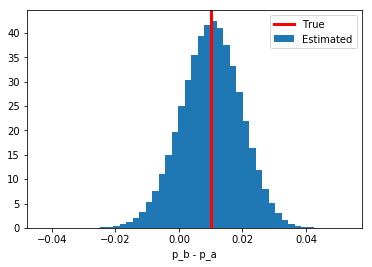

In [10]:
plt.hist(diffs, bins=int(1 + np.log(len(diffs)) * 3.33), label='Estimated', density=True)
plt.axvline(TRUE_ABS_INCREASE, label="True", color='red', linewidth=3)
plt.legend()
plt.xlabel("p_b - p_a")
plt.show()

##### Распределение исходных параметров

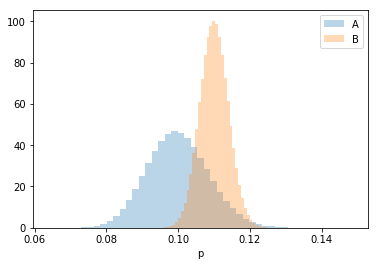

In [11]:
plt.hist(beta_a.rvs(SIM_SIZE), bins=int(1 + np.log(len(diffs)) * 3.33), label='A', density=True, alpha=0.3)
plt.hist(beta_b.rvs(SIM_SIZE), bins=int(1 + np.log(len(diffs)) * 3.33), label='B', density=True, alpha=0.3)
plt.legend()
plt.xlabel('p')
plt.show()

# Непрерывная величина

Посмотрим на рекламный доход на 7-ий день органики и платного трафика.

In [22]:
data = execute("""
WITH inst AS (
SELECT DISTINCT
    appsflyerId,
    IF(mediaSource = "organic", "organic", "paid") AS traffic_type
FROM
    `playgendary-bi.aggregated_data.installs_cost`
WHERE
    installDate = "2021-06-01"
    AND appId = "id1435346021"
    AND countryCode = "US" 
    AND appsflyerId IS NOT NULL
),
revenue AS (
SELECT
    appsflyerId,   
    SUM(revenue) AS ad
FROM
    `playgendary-bi.aggregated_data.daily_ad_revenue`
WHERE
    revenueDate BETWEEN "2021-06-01" AND DATE_ADD("2021-06-01", INTERVAL 7 DAY)
    AND installDate = "2021-06-01"
    AND appId = "id1435346021"
    AND countryCode = "US"
GROUP BY
    appsflyerId
)

SELECT
    appsflyerId,
    traffic_type,
    IFNULL(ad, 0) AS ad
FROM
    inst
LEFT JOIN
    revenue
USING(appsflyerId)
""")

data.to_csv("data.csv", index=False)
data = pd.read_csv("data.csv")

Requesting query... 
Query running...
Job ID: 45f2ab80-0598-4415-a672-dc1cd10f9ab4
Query done.
Processed: 545.1 MB Billed: 546.0 MB
Standard price: $0.00 USD

Downloading: 100%|██████████| 5332/5332 [00:00<00:00, 13742.40rows/s]
Got 5332 rows.



In [23]:
data_organic = data.loc[data['traffic_type'] == "organic"]['ad'].values
data_paid = data.loc[data['traffic_type'] == "paid"]['ad'].values

#### Для денежных метрик хорошо подходит логнормальное распределение. Воспользуемся тем фактом, что логарифм логнормальной величины распределён нормально, затем воспользуемся сопряженным распределением для неизвестной средней и дисперсии нормальной величины.

https://en.wikipedia.org/wiki/Conjugate_prior
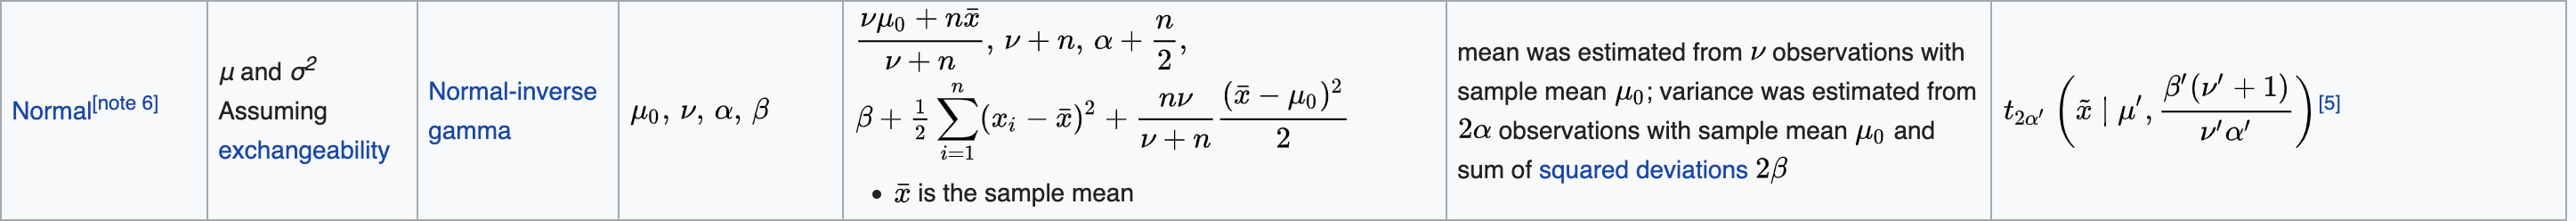

Посмотрим на игроков, которые хоть раз посмотрели рекламу, чтобы убедиться в применимости логнормального распределения.
Если игроков несмотревших рекламу много придется использовать смесь бернулли и логнормального (логнормальное распределение поддерживает строго положительные величины).

In [24]:
print('organic engaged users, %:', (data_organic > 0).sum() / data_organic.shape[0] * 100)
data_organic_pos = data_organic[data_organic > 0]

print('paid engaged users, %:', (data_paid > 0).sum() / data_paid.shape[0] * 100)
data_paid_pos = data_paid[data_paid > 0]

organic engaged users, %: 84.50082735797021
paid engaged users, %: 83.94430235862461


In [25]:
prior_mu, prior_v, prior_alpha, prior_beta = 0, 1, 1, 1

In [26]:
from scipy.stats import norm, invgamma

In [27]:
def generate_samples(data, mu, v, alpha, beta, sim_size=10000):
    x = np.log(data)
    size = len(x)
    sample_mean = x.mean()
    sum_square_dev = ((x - sample_mean) ** 2).sum()

    poster_mu = (v * mu + size * sample_mean) / (v + size)
    poster_v = v + size
    poster_alpha = alpha + size / 2

    poster_beta_1 = beta + sum_square_dev / 2
    poster_beta_2_1 = ((size * v) / (size + v))
    poster_beta_2_2 = ((sample_mean - mu) ** 2) / 2
    poster_beta = poster_beta_1 + poster_beta_2_1 * poster_beta_2_2
    
    # в scpity нет распределения в готовом виде, но нужные величины можно получить в две отдельные симуляции
    sigma_distr = invgamma(poster_alpha, scale=poster_beta)
    sigma2_samples = sigma_distr.rvs(size=sim_size)

    mu_dist = norm(poster_mu, np.sqrt(sigma2_samples) / poster_v)
    mu_samples = mu_dist.rvs(size=sim_size)
    
    return mu_samples, sigma2_samples

In [28]:
mu_samples_organic, sigma2_samples_organic = generate_samples(
    data_organic_pos, 
    prior_mu, prior_v, prior_alpha, prior_beta)
# формула мат ожидания логнормальной величины
log_norm_mu_samples_organic = np.exp(mu_samples_organic + sigma2_samples_organic/2)

mu_samples_paid, sigma2_samples_paid = generate_samples(
    data_paid_pos,
    prior_mu, prior_v, prior_alpha, prior_beta)
log_norm_mu_samples_paid = np.exp(mu_samples_paid + sigma2_samples_paid/2)

In [29]:
print('P(organic > paid | data) =', (log_norm_mu_samples_organic > log_norm_mu_samples_paid).mean())

P(organic > paid | data) = 1.0


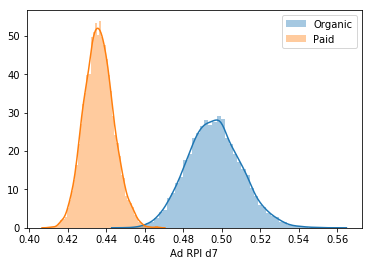

In [30]:
sns.distplot(log_norm_mu_samples_organic, label="Organic")
sns.distplot(log_norm_mu_samples_paid, label="Paid")
plt.legend()
plt.xlabel('Ad RPI d7')
plt.show()

In [31]:
print('95% conf interval, organic:', np.percentile(log_norm_mu_samples_organic, [0.05, 0.95]))
print('95% conf interval, paid:', np.percentile(log_norm_mu_samples_paid, [0.05, 0.95]))

95% conf interval, organic: [0.45602034 0.46542007]
95% conf interval, paid: [0.41318343 0.41936713]


### Вывод:
В платном трафике средний рекламный доход на одного игрока, смотрящего рекламу, меньше чем в органическом с вероятностью >99%.